In [1]:
# open file list_attr_celeba.txt and read the content in a list

import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img_path = "data/img_align_celeba"
df = pd.read_csv("data/list_attr_celeba.csv")
df = df.head(10000)
print(df.columns)
with_glasses = df['image_id'][(df['Eyeglasses'] == 1) & (df['Male']==1)].tolist()
without_glasses = df['image_id'][(df['Eyeglasses'] == -1) & (df['Male']==1)].tolist()

print(len(with_glasses))
print(len(without_glasses))

print(with_glasses[-5])




Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
524
3693
009868.jpg


In [2]:
# load ids for images
img_id_map = dict()
images_for_id = dict()
with open("data/identity_CelebA.txt", "r") as file:
    file_list = file.readlines()
    for line in file_list:
        img = line.split()[0]
        id = line.split()[1]
        img_id_map[img] = id
        if id not in images_for_id:
            images_for_id[id] = []
        images_for_id[id].append(img)


print("Distinct ids:", len(set(img_id_map.values())))

cnt = 0
set1 = set(img_id_map[i] for i in with_glasses)
set2 = set(img_id_map[i] for i in without_glasses)
print(len(set1))
print(len(set2))

with_and_without_glasses = list(set1.intersection(set2))
print("Number of same people with and without glasses:", len(with_and_without_glasses))


Distinct ids: 10177
393
2166
Number of same people with and without glasses: 178


In [3]:
rand_ids = np.random.choice(with_and_without_glasses, 5)
f = plt.figure()
plt.axis('off')
f.set_figheight(100)
f.set_figwidth(100)
for i in range(5):
    id = rand_ids[i]
    with_beard_img = np.random.choice(images_for_id[id])
    without_beard_img = np.random.choice(images_for_id[id])
    while with_beard_img not in with_glasses:
        with_beard_img = np.random.choice(images_for_id[id])
    while without_beard_img not in without_glasses:
        without_beard_img = np.random.choice(images_for_id[id])
    
    with_beard_img = Image.open(os.path.join("data/img_align_celeba", with_beard_img))
    without_beard_img = Image.open(os.path.join("data/img_align_celeba", without_beard_img))
    f.add_subplot(5, 2, 2*i + 1)
    plt.imshow(with_beard_img)
    f.add_subplot(5, 2, 2*i + 2)
    plt.imshow(without_beard_img)
    print("")






Error in callback <function _draw_all_if_interactive at 0x000002BC4698A3A0> (for post_execute):


KeyboardInterrupt: 

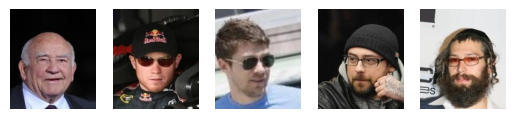

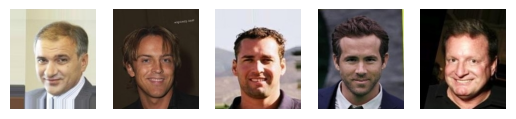

In [ ]:
glass_images = [Image.open(f'{img_path}/{with_glasses[np.random.randint(0, len(with_glasses))]}') for i in range(5)]
f = plt.figure()
for i in range(5):
    # Debug, plot figure
    f.add_subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(glass_images[i])

plt.show(block=True) 

no_glass_images = [Image.open(f'{img_path}/{without_glasses[np.random.randint(0, len(without_glasses))]}') for i in range(5)]
f = plt.figure()
for i in range(5):
    # Debug, plot figure
    f.add_subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(no_glass_images[i])

plt.show(block=True) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


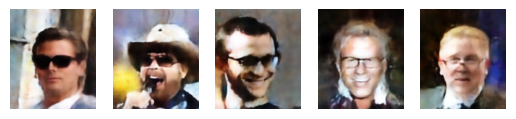

In [ ]:
from VanillaVAE import VanillaVAE
import torch
from torchvision import transforms


INPUT_DIM = 3
Z_DIM = 1000
PATH = "model_prvenac.pt"
device = torch.device('cpu')

model = VanillaVAE(INPUT_DIM, Z_DIM)
checkpoint = torch.load(PATH,map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

transform=transforms.ToTensor()

f = plt.figure()
for i in range(len(glass_images)):
    with torch.no_grad():
        out = model.forward(transform(glass_images[i]).unsqueeze(0).to(device))[0]
        
    out = out.view(-1, 3, 224, 192)
    out = np.transpose(out, (0, 2, 3, 1))
    f.add_subplot(1, len(glass_images), i + 1)
    plt.axis('off')
    plt.imshow(out[0])



In [ ]:
from CustomDataset import CustomDataset
from torchvision import transforms
from torch.utils.data import DataLoader


def get_avg_mu(labels):

    batch_size = 32
    glasses_dataset = CustomDataset("data/img_align_celeba/",labels,transforms.ToTensor())
    glasses_loader = DataLoader(glasses_dataset, batch_size=batch_size, shuffle=True)

    mu_sum = torch.Tensor(1000)
    sigma_sum = torch.Tensor(1000)
    count = 0
    for batch in glasses_loader:
        count += batch.shape[0]
        batch = batch.to(device)
        mu, sigma = model.encode(batch)
        # print(mu[0][:5])
        mu_sum = mu_sum + mu.T.sum(dim=1)
        sigma_sum = sigma_sum + sigma.T.sum(dim=1)
        # print(sigma_sum.shape)
    
    print(count)
    mu_avg = mu_sum/count
    sigma_avg = sigma_sum/count

    print(sigma_sum.shape)
    return mu_avg
 

In [ ]:
mu_avg_glasses = get_avg_mu(with_glasses)
# mu_avg_no_glasses = get_avg_mu(without_glasses)
mu_avg_no_glasses = get_avg_mu(without_glasses[:len(with_glasses)])

delta_mu = mu_avg_glasses - mu_avg_no_glasses
print(delta_mu.shape)


0
524
torch.Size([1000])
0
524
torch.Size([1000])
torch.Size([1000])


In [ ]:
torch.save(delta_mu, 'delta_mu.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


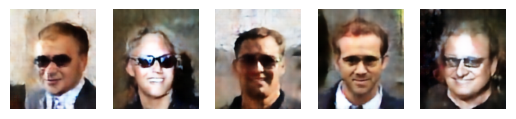

In [ ]:
f = plt.figure()
for i in range(len(no_glass_images)):
    with torch.no_grad():
        x = transform(no_glass_images[i]).unsqueeze(0).to(device)
        # x = torch.rand_like(transform(no_glass_images[i]).unsqueeze(0)).to(device) 
        # x = torch.zeros_like(x).to(device)
        out = model.generate_with_delta(x,delta_mu*5) #torch.zeros_like(delta_mu))
        
    out = out.view(-1, 3, 224, 192)
    out = np.transpose(out, (0, 2, 3, 1))
    f.add_subplot(1, len(no_glass_images), i + 1)
    plt.axis('off')
    plt.imshow(out[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
x
1
y


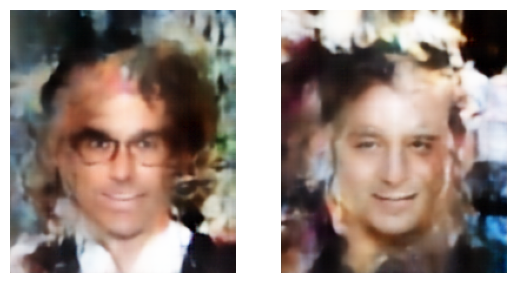

In [ ]:
f = plt.figure()
for i in range(2):
    print(i)
    with torch.no_grad():
        if i==0:
            print("x")
            out = model.generate_with_only_mu(mu_avg_glasses)
        else:
            print("y")
            out = model.generate_with_only_mu(mu_avg_no_glasses)
    out = out.view(-1, 3, 224, 192)
    out = np.transpose(out, (0, 2, 3, 1))
    f.add_subplot(1, 2, i + 1)
    plt.axis('off')
    plt.imshow(out[0])

In [ ]:
print(mu_avg_glasses)

tensor([-9.5275e-04,  8.1200e-02, -1.7121e-01, -3.8310e-01,  5.8542e-03,
        -1.6026e-01, -6.7608e-02,  1.0326e-02,  2.1472e-01, -1.9571e-02,
        -8.1363e-03, -5.7752e-02, -5.2733e-02, -2.6852e-02, -1.0903e-01,
        -1.4819e-01,  2.2249e-01, -7.1211e-02, -7.7661e-02, -3.8388e-02,
        -1.5276e-01, -5.9951e-02,  7.2019e-03, -7.5029e-02,  1.9045e-02,
         7.2940e-02,  1.1663e-01, -5.6606e-02, -1.1341e-02, -1.0165e-01,
         8.4112e-02,  4.2413e-02,  8.7021e-02,  2.6732e-02,  5.0050e-02,
        -5.5033e-02, -1.6435e-01,  2.0716e-02,  8.0965e-02,  3.6900e-02,
         1.1819e-01,  7.7074e-02, -6.0735e-02,  3.2534e-02,  1.2205e-01,
        -2.9498e-02,  1.5732e-02,  1.7463e-01,  9.1225e-02,  6.9356e-03,
         3.5502e-01, -1.7531e-02, -8.8077e-03, -7.2418e-02,  7.9962e-02,
         7.7185e-02,  8.9640e-03, -5.2973e-02,  6.7744e-02,  2.9504e-03,
         6.4371e-02, -1.5697e-02,  2.0559e-02,  7.4950e-02, -8.4697e-02,
        -3.7096e-02, -2.6483e-02,  8.5444e-02, -1.1

In [ ]:
print(mu_avg_no_glasses)

tensor([ 6.8582e-02,  1.0370e-01, -2.3777e-02, -3.1582e-01,  7.8121e-02,
        -2.5994e-02, -4.6281e-02,  4.2438e-02, -1.5594e-01,  8.0129e-03,
        -2.0333e-03, -8.0008e-02, -3.6057e-03, -1.7329e-02, -2.1139e-02,
        -9.5712e-02, -2.9371e-04, -1.0657e-01, -2.3327e-03, -4.8218e-02,
        -6.2762e-02, -1.9004e-02,  7.8083e-03, -4.2247e-02,  2.7430e-02,
        -7.1935e-02,  1.1150e-01, -1.0426e-02,  5.4767e-02, -8.1957e-02,
        -2.2391e-02, -1.9304e-02,  2.3415e-02,  3.0276e-02,  3.6072e-03,
        -8.2618e-02, -9.6078e-02,  3.5232e-02, -2.3997e-02,  8.2317e-02,
         5.3618e-02, -2.5037e-01, -4.1249e-02,  9.2780e-03,  5.4852e-02,
         5.5889e-02,  5.1911e-02,  4.2300e-02,  1.1091e-01, -6.6271e-04,
        -5.6051e-02, -2.6529e-02,  4.8986e-02,  1.0063e-02, -8.8627e-03,
        -8.7471e-02, -8.8754e-02, -4.0260e-02,  5.8280e-02,  3.1134e-02,
         4.8889e-02, -1.1937e-02,  1.9447e-02,  3.7835e-02, -5.0716e-02,
        -5.7945e-02, -3.9001e-02, -2.3533e-02, -9.8